In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../../')

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.sde import BrownianSDE
from sdebridge.utils import *

plt.style.use('ggplot')

## 1 Dimensional

In [3]:
d = 1
sde = BrownianSDE(dimension=d, num_steps=100)
bridge = DiffusionBridge(sde=sde)

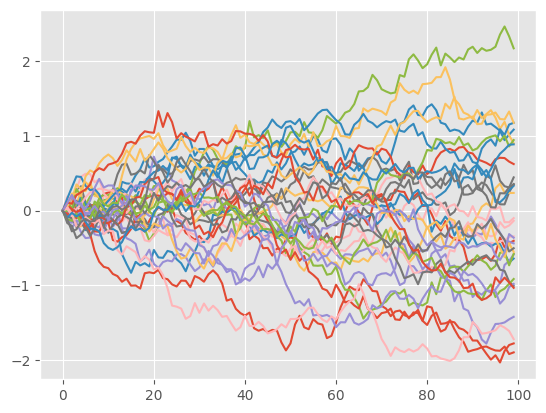

In [4]:
forward_brownian_motion = bridge.simulate_forward_process(initial_val=jnp.tile(jnp.array([[0.0]]), reps=(32, 1)),
                                                          rng=jax.random.PRNGKey(232))
for i in range(32):
    plt.plot(forward_brownian_motion["trajectories"][i, :, 0])

In [5]:
setup_params = {
    "network": {"out_dim": sde.d,
                "time_embedding_dim": 64,
                "embedding_dim": 64,
                "act": 'gelu',
                "encoder_layer_dims": [32, 32],
                "decoder_layer_dims": [32, 32],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 20,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_state = bridge.learn_p_score(initial_val=jnp.array([0.0]), 
                                     setup_params=setup_params,
                                     rng=jax.random.PRNGKey(21),
                                     loss_calibration=True)

Training: 100%|██████████| 20/20 [00:03<00:00,  5.19epoch/s, Epoch=20, loss=-0.0077]


In [6]:
setup_params = {
    "network": {"out_dim": sde.d,
                "time_embedding_dim": 64,
                "embedding_dim": 64,
                "act": 'gelu',
                "encoder_layer_dims": [32, 32],
                "decoder_layer_dims": [32, 32],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 20,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=jnp.array([0.0]),
                                               terminal_val=jnp.array([2.0]),
                                               score_p=jax.tree_util.Partial(eval_score, state=score_p_state),
                                               setup_params=setup_params,
                                               rng=jax.random.PRNGKey(112),
                                               loss_calibration=True)

Training: 100%|██████████| 20/20 [00:04<00:00,  4.97epoch/s, Epoch=20, loss=0.0713]


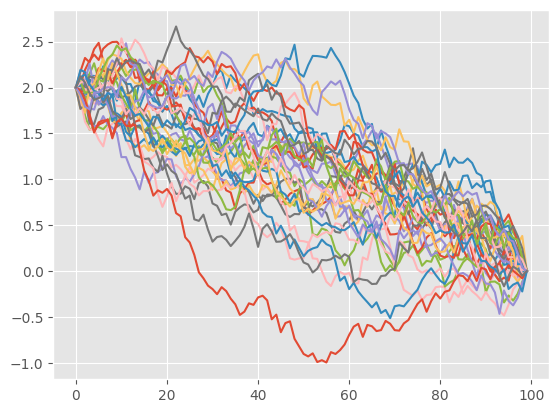

In [7]:
score_p = jax.tree_util.Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=jnp.tile(jnp.array([[0.0]]), reps=(32, 1)), 
                                                           terminal_val=jnp.tile(jnp.array([[2.0]]), reps=(32, 1)),
                                                           score_p=score_p,
                                                           rng=jax.random.PRNGKey(113))
for i in range(32):
    plt.plot(backward_brownian_bridge["trajectories"][i, :, 0])

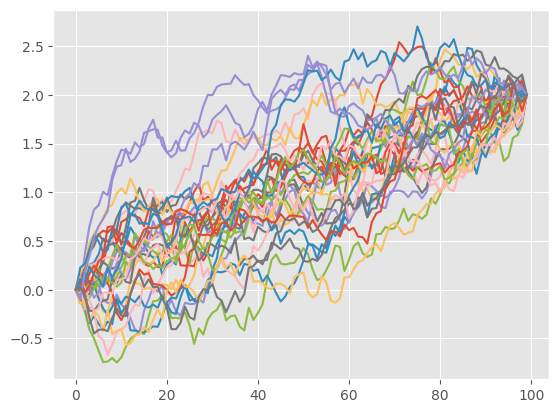

In [8]:
score_h = jax.tree_util.Partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=jnp.tile(jnp.array([[0.0]]), reps=(32, 1)), 
                                                         terminal_val=jnp.tile(jnp.array([[2.0]]), reps=(32, 1)),
                                                         score_h=score_h,
                                                         rng=jax.random.PRNGKey(114))
for i in range(32):
    plt.plot(forward_brownian_bridge["trajectories"][i, :, 0])

## 2 Dimensional

### Learn the transition density of $X_t$

In [9]:
d = 2
sde = BrownianSDE(dimension=d, num_steps=100)
bridge = DiffusionBridge(sde=sde)

(32, 100, 2)


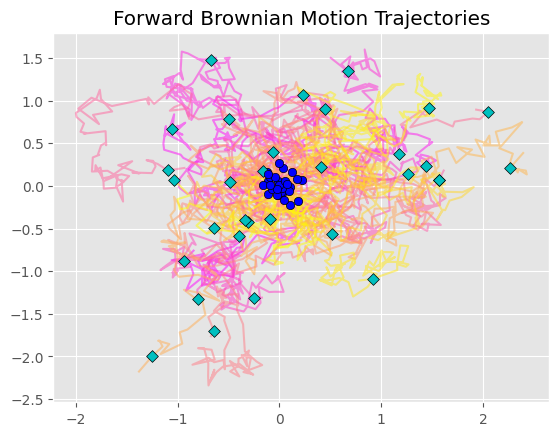

In [10]:
forward_brownian_motion = bridge.simulate_forward_process(initial_val=jnp.tile(jnp.array([[0.0, 0.0]]), reps=(32, 1)), 
                                                          rng=jax.random.PRNGKey(3214))
print(forward_brownian_motion["trajectories"].shape)
plot_2d_trajectories(forward_brownian_motion["trajectories"], title="Forward Brownian Motion Trajectories")

In [11]:
setup_params = {
    "network": {"out_dim": sde.d,
                "time_embedding_dim": 64,
                "embedding_dim": 64,
                "act": 'gelu',
                "encoder_layer_dims": [64, 64],
                "decoder_layer_dims": [64, 64],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_state = bridge.learn_p_score(initial_val=jnp.array([0.0, 0.0]), 
                                     setup_params=setup_params,
                                     rng=jax.random.PRNGKey(132),
                                     loss_calibration=True)

Training: 100%|██████████| 50/50 [00:13<00:00,  3.63epoch/s, Epoch=50, loss=-0.0150]


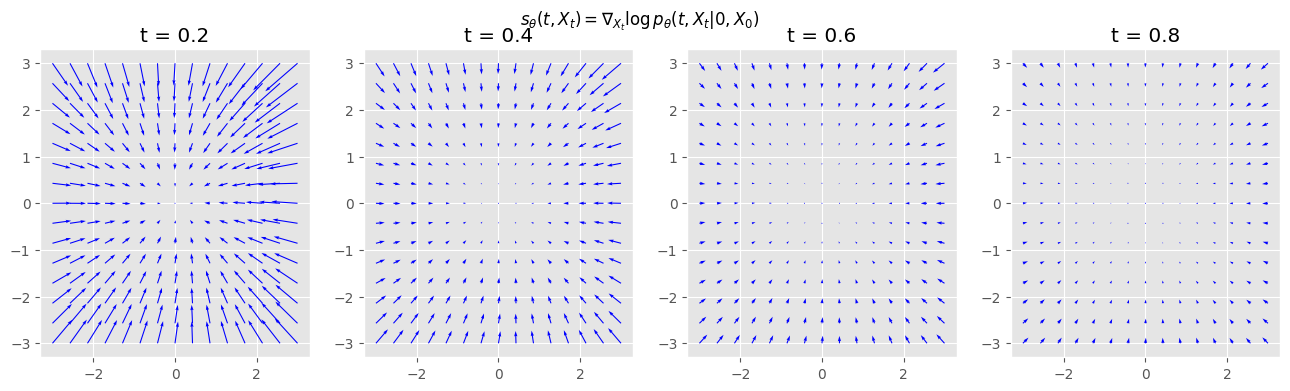

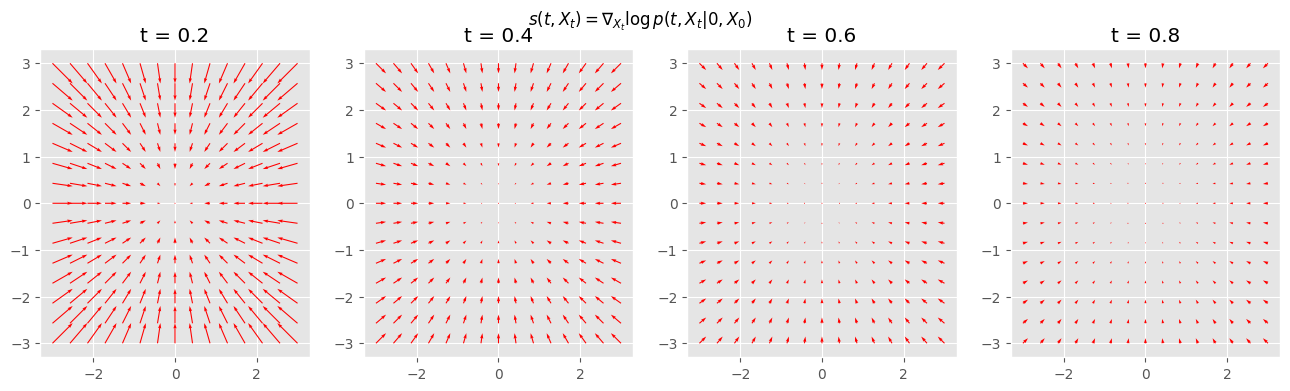

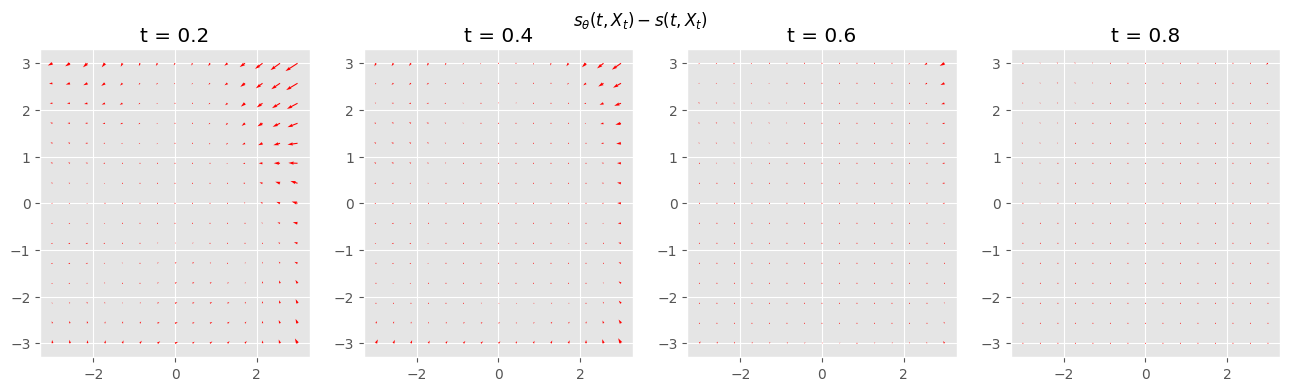

In [12]:
plot_2d_vector_field(X=lambda x, t: eval_score(score_p_state, x, t),
                     X_ref=None,
                     xs=jnp.linspace(-3.0, 3.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s_{\theta}(t, X_t)=\nabla_{X_t}\log p_{\theta}(t, X_t|0, X_0)$",
                     scale=200)

plot_2d_vector_field(X=None,
                     X_ref=lambda x, t, x0: -(x-x0)/t,
                     xs=jnp.linspace(-3.0, 3.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s(t, X_t)=\nabla_{X_t}\log p(t,X_t|0,X_0)$",
                     scale=200,
                     x0=jnp.array([0.0, 0.0]))

plot_2d_vector_field(X=None,
                     X_ref=lambda x, t, x0: eval_score(score_p_state, x, t) - (-(x-x0)/t),
                     xs=jnp.linspace(-3.0, 3.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s_{\theta}(t, X_t) - s(t, X_t)$",
                     scale=200,
                     x0=jnp.array([0.0, 0.0]))

### Use learned transition score to simulate the backward bridge

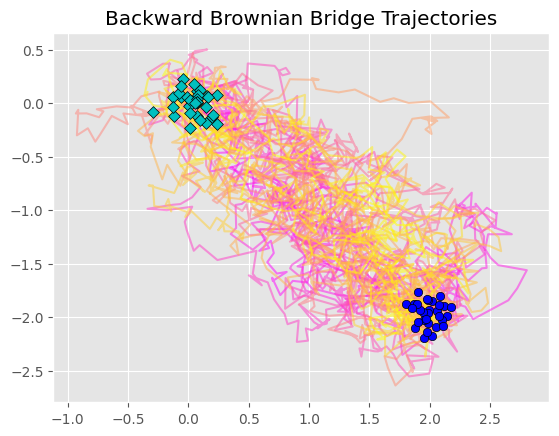

In [13]:
score_p = jax.tree_util.Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=jnp.tile(jnp.array([[0.0, 0.0]]), reps=(32, 1)), 
                                                           terminal_val=jnp.tile(jnp.array([[2.0, -2.0]]), reps=(32, 1)),
                                                           score_p=score_p,
                                                           rng=jax.random.PRNGKey(1145))
plot_2d_trajectories(backward_brownian_bridge["trajectories"], title="Backward Brownian Bridge Trajectories")

### Learn the transition density of the forward bridge from the simulated backward bridge

In [14]:
setup_params = {
    "network": {"out_dim": sde.d,
                "time_embedding_dim": 64,
                "embedding_dim": 64,
                "act": 'leaky_relu',
                "encoder_layer_dims": [64, 64],
                "decoder_layer_dims": [64, 64],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=jnp.array([0.0, 0.0]),
                                               terminal_val=jnp.array([2.0, 0.0]),
                                               score_p=score_p,
                                               setup_params=setup_params,
                                               rng=jax.random.PRNGKey(141),
                                               loss_calibration=True)

Training: 100%|██████████| 50/50 [00:14<00:00,  3.48epoch/s, Epoch=50, loss=0.0351]


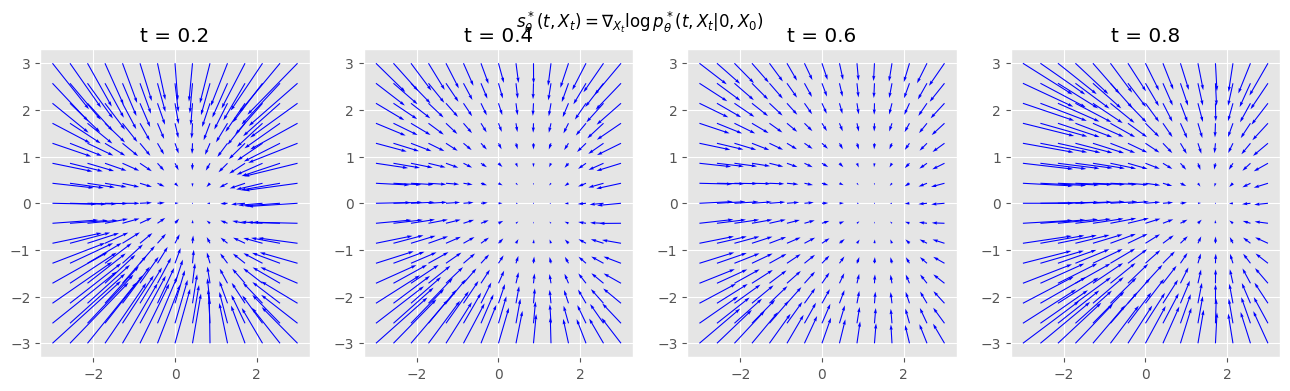

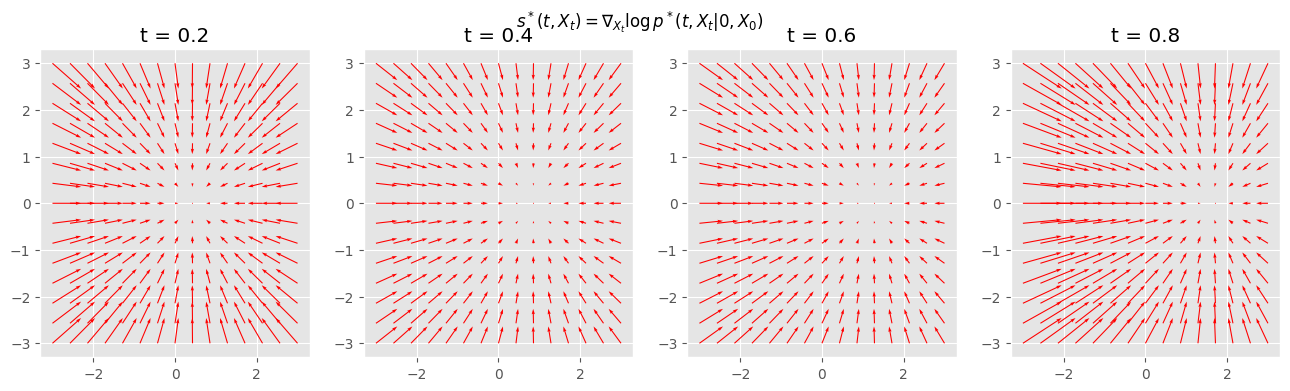

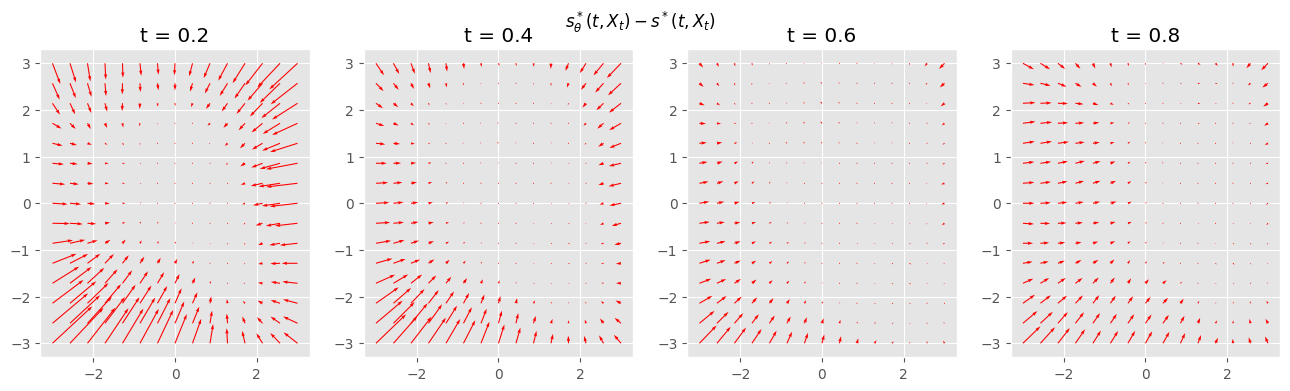

In [15]:
plot_2d_vector_field(X=lambda x, t: eval_score(score_p_star_state, x, t),
                     X_ref=None,
                     xs=jnp.linspace(-3.0, 3.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s^*_{\theta}(t, X_t)=\nabla_{X_t}\log p^*_{\theta}(t, X_t|0, X_0)$",
                     scale=200)

plot_2d_vector_field(X=None,
                     X_ref=lambda x, t, x0, xT, T: -(x-xT) / (T-t) - (x-x0) / t,
                     xs=jnp.linspace(-3.0, 3.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s^*(t, X_t)=\nabla_{X_t}\log p^*(t,X_t|0,X_0)$",
                     x0=jnp.array([0.0, 0.0]),
                     xT=jnp.array([2.0, 0.0]),
                     scale=200,
                     T=1.0)

plot_2d_vector_field(X=None,
                     X_ref=lambda x, t, x0, xT, T: eval_score(score_p_star_state, x, t) + (x-xT) / (T-t) + (x-x0) / t,
                     xs=jnp.linspace(-3.0, 3.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s^*_{\theta}(t, X_t) - s^*(t, X_t)$",
                     scale=200,
                     x0=jnp.array([0.0, 0.0]),
                     xT=jnp.array([2.0, 0.0]),
                     T=1.0)

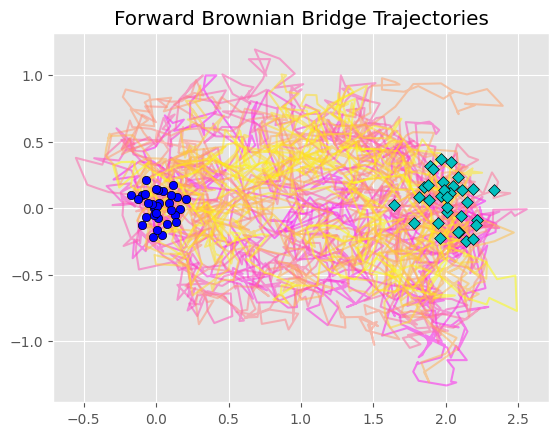

In [16]:
score_h = jax.tree_util.Partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=jnp.tile(jnp.array([[0.0, 0.0]]), reps=(32, 1)), 
                                                         terminal_val=jnp.tile(jnp.array([[2.0, 0.0]]), reps=(32, 1)),
                                                         score_h=score_h,
                                                         rng=jax.random.PRNGKey(1145))
plot_2d_trajectories(forward_brownian_bridge["trajectories"], title="Forward Brownian Bridge Trajectories")

### Higher dimension

In [39]:
d = 64
sde = BrownianSDE(dimension=d, num_steps=50)
bridge = DiffusionBridge(sde=sde)

(64,) (64,)


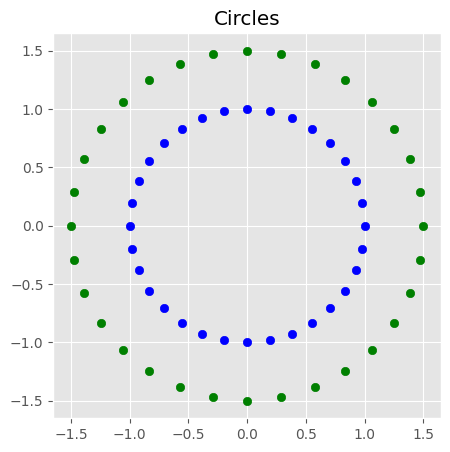

In [40]:
circles1 = sample_circle(num_points=d//2, scale=1.0, shifts=jnp.array([0.0, 0.0]))
circles2 = sample_circle(num_points=d//2, scale=1.5, shifts=jnp.array([0.0, 0.0]))
# squares = sample_square(num_points=d//2, scale=1.0, shifts=jnp.array([0.0, 0.0]))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(circles1.reshape(-1, 2)[:, 0], circles1.reshape(-1, 2)[:, 1], color='b')
# ax.scatter(squares.reshape(-1, 2)[:, 0], squares.reshape(-1, 2)[:, 1], color='r')
ax.scatter(circles2.reshape(-1, 2)[:, 0], circles2.reshape(-1, 2)[:, 1], color='g')
ax.set_title("Circles")
print(circles1.shape, circles2.shape)

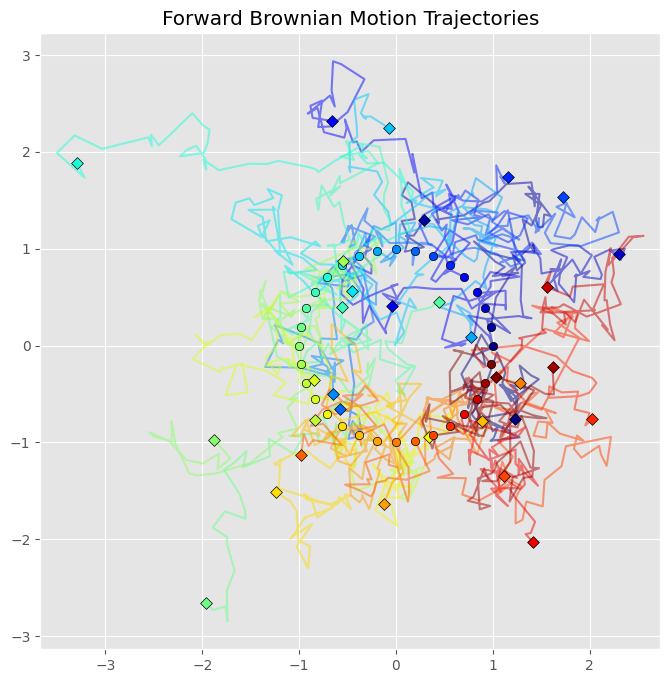

In [41]:
forward_brownian_motion = bridge.simulate_forward_process(initial_val=jnp.tile(circles1, reps=(1, 1)), rng=jax.random.PRNGKey(3214))
plot_single_trajectory(forward_brownian_motion["trajectories"][0], title="Forward Brownian Motion Trajectories")

In [42]:
setup_params = {
    "network": {"out_dim": sde.d,
                "time_embedding_dim": 128,
                "embedding_dim": 256,
                "act": 'gelu',
                "encoder_layer_dims": [256, 256, 256],
                "decoder_layer_dims": [256, 256, 256],
                "using_batchnorm": False},
    "training": {"batch_size": 64,
                 "num_epochs": 30,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_state = bridge.learn_p_score(initial_val=circles1, 
                                     setup_params=setup_params,
                                     rng=jax.random.PRNGKey(132),
                                     loss_calibration=False)

Training: 100%|██████████| 30/30 [04:26<00:00,  8.89s/epoch, Epoch=30, loss=29.5348]


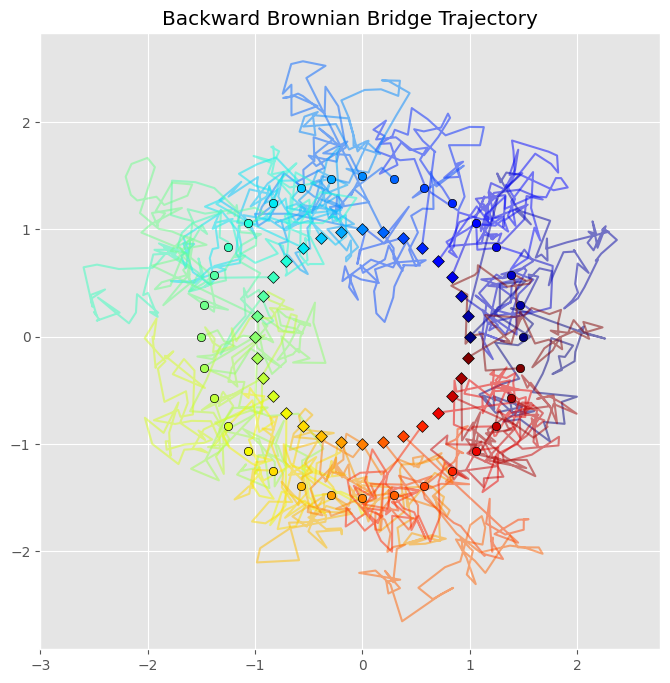

In [48]:
score_p = jax.tree_util.Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=jnp.tile(circles1, reps=(1, 1)), 
                                                           terminal_val=jnp.tile(circles2, reps=(1, 1)),
                                                           score_p=score_p,
                                                           rng=jax.random.PRNGKey(1432))
plot_single_trajectory(backward_brownian_bridge["trajectories"][0], title="Backward Brownian Bridge Trajectory")

In [49]:
setup_params = {
    "network": {"out_dim": sde.d,
                "time_embedding_dim": 128,
                "embedding_dim": 256,
                "act": 'gelu',
                "encoder_layer_dims": [256, 256, 256],
                "decoder_layer_dims": [256, 256, 256],
                "using_batchnorm": False},
    "training": {"batch_size": 64,
                 "num_epochs": 30,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=circles1,
                                               terminal_val=circles2,
                                               score_p=score_p,
                                               setup_params=setup_params,
                                               rng=jax.random.PRNGKey(141),
                                               loss_calibration=False)

Training: 100%|██████████| 30/30 [07:06<00:00, 14.23s/epoch, Epoch=30, loss=28.0018]


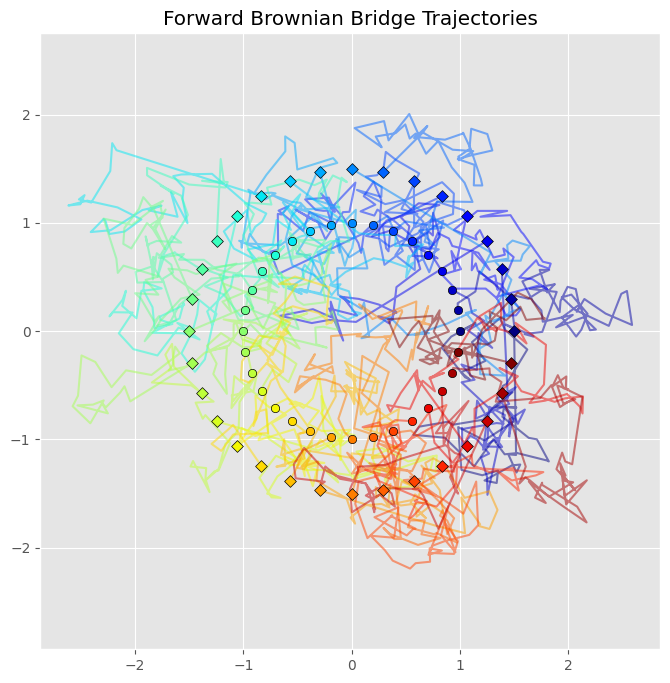

In [50]:
score_h = jax.tree_util.Partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=jnp.tile(circles1, reps=(1, 1)), 
                                                         terminal_val=jnp.tile(circles2, reps=(1, 1)),
                                                         score_h=score_h,
                                                         rng=jax.random.PRNGKey(1537))
plot_single_trajectory(forward_brownian_bridge["trajectories"][0], title="Forward Brownian Bridge Trajectories")